# "Работа с заботой"

## Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
***
Будет несколько задач:

1) Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

2) Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Описание данных для задач

**Задача 1: предсказание уровня удовлетворённости сотрудника**

Для этой задачи заказчик предоставил данные с признаками:

- ***id*** — уникальный идентификатор сотрудника;

- ***dept*** — отдел, в котором работает сотрудник;

- ***level*** — уровень занимаемой должности;

- ***workload*** — уровень загруженности сотрудника;

- ***employment_years*** — длительность работы в компании (в годах);

- ***last_year_promo*** — показывает, было ли повышение за последний год;

- ***last_year_violations*** — показывает, нарушал ли сотрудник трудовой договор за последний год;

- ***supervisor_evaluation*** — оценка качества работы сотрудника, которую дал руководитель;

- ***salary*** — ежемесячная зарплата сотрудника;

- ***job_satisfaction_rate*** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

**Задача 2: предсказание увольнения сотрудника из компании**

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это ***quit*** — увольнение сотрудника из компании.

## Загрузка данных 1

In [1]:
!pip install scikit-learn==1.1.3 -q

In [2]:
!pip install --upgrade scikit-learn

  Using cached scikit_learn-1.5.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.4 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3


In [3]:
!pip install phik -q

In [4]:
!pip install shap

In [5]:
import pandas as pd # загрузка необходимых библиотек
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import phik
from sklearn.dummy import DummyRegressor, DummyClassifier
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_classif

In [6]:
data_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep=',')
data_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
data_test = pd.read_csv('/datasets/test_features.csv', sep=',')
data_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [10]:
goal_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',')
goal_test.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [11]:
goal_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [12]:
data = data_test.merge(goal_test, on='id', how='inner')
data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


## Предобработка данных 1

Проверим датафреймы на явные и неявные дубликаты, прежде чем делить на X_train, y_train, X_test и y_test

In [13]:
data_train.duplicated().sum() #проверка на явные дубли

0

In [14]:
data_test.duplicated().sum()

0

In [15]:
goal_test.duplicated().sum()

0

In [16]:
print(data_train['dept'].unique(), '\n') #проверка на неявные дубли
print(data_test['dept'].unique(), '\n')
print(data_train['level'].unique(), '\n') 
print(data_test['level'].unique(), '\n')
print(data_train['workload'].unique(), '\n') 
print(data_test['workload'].unique(), '\n')
print(data_train['last_year_promo'].unique(), '\n') 
print(data_test['last_year_promo'].unique(), '\n')
print(data_train['last_year_violations'].unique(), '\n') 
print(data_test['last_year_violations'].unique(), '\n')

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan] 

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 

['junior' 'middle' 'sinior' nan] 

['junior' 'middle' 'sinior' nan] 

['medium' 'high' 'low'] 

['medium' 'low' 'high' ' '] 

['no' 'yes'] 

['no' 'yes'] 

['no' 'yes'] 

['no' 'yes'] 



Видим, что в тестовой выборке есть пропуски в виде пробелов, заменим их на пропуски.

In [17]:
data['dept'] = data['dept'].replace(' ', np.nan)
data['workload'] = data['workload'].replace(' ', np.nan)
data['level'] = data['level'].replace('sinior', 'senior')
data_train['level'] = data_train['level'].replace('sinior', 'senior')

Отлично, в данных дубликатов нет, можем  продолжать работу и выделить соответствующие выборки для анализа.

In [18]:
imputer_pipe =  Pipeline([('simpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]) #pipe для пропусков
imputer_col = ['dept', 'level', 'workload']
data_train[imputer_col] = imputer_pipe.fit_transform(data_train[imputer_col])
data[imputer_col] = imputer_pipe.transform(data[imputer_col])
data['dept'].unique() #проверка

array(['marketing', 'hr', 'sales', 'purchasing', 'technology'],
      dtype=object)

In [19]:
X_train = data_train.drop('id', axis=1)
prepare = X_train.drop_duplicates()
X_train = prepare.drop('job_satisfaction_rate', axis=1)
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000
3,technology,junior,low,4,no,no,2,18000
4,hr,junior,medium,1,no,no,3,22800


In [20]:
y_train = prepare['job_satisfaction_rate']
y_train

0       0.58
1       0.76
2       0.11
3       0.37
4       0.20
        ... 
3993    0.88
3994    0.27
3997    0.76
3998    0.48
3999    0.18
Name: job_satisfaction_rate, Length: 3752, dtype: float64

In [21]:
X_test = data.drop(['id', 'job_satisfaction_rate'], axis=1)
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,marketing,junior,medium,2,no,no,5,28800
1,hr,junior,medium,1,no,no,4,30000
2,sales,middle,low,5,no,no,4,19200
3,sales,middle,low,6,no,no,4,19200
4,hr,middle,medium,5,no,no,5,40800


In [22]:
y_test = data['job_satisfaction_rate']
y_test

0       0.79
1       0.72
2       0.64
3       0.60
4       0.75
        ... 
1995    0.56
1996    0.14
1997    0.11
1998    0.43
1999    0.67
Name: job_satisfaction_rate, Length: 2000, dtype: float64

Исследуя данные на дубликаты, мы увидели в них пропуски, будем их обрабатывать.

Отлично, с пропусками мы разобрались, теперь будем переходить к исследовательскому анализу.

## Исследовательский анализ данных 1

Посмотрим на корреляцию между признаками.

In [23]:
sns.set_theme(rc={'figure.figsize':(12,12)})
data_corr_train = data_train.drop('id', axis=1)
interval_cols= ['salary', 'job_satisfaction_rate']

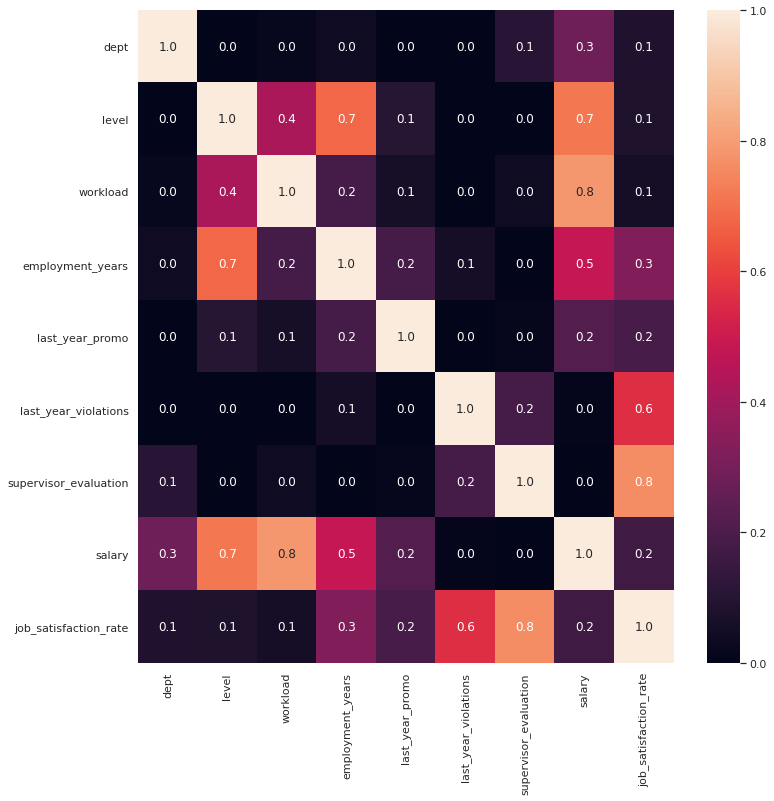

In [24]:
sns.heatmap(data_corr_train.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.1f')
plt.show()

Судя по тепловой карте для тренировочной выборки, можем заметить, что целевой признак ***заметно*** коррелирует с нарушениями сотрудника за последний год, и ***высоко*** - с оценкой работника руководителем.

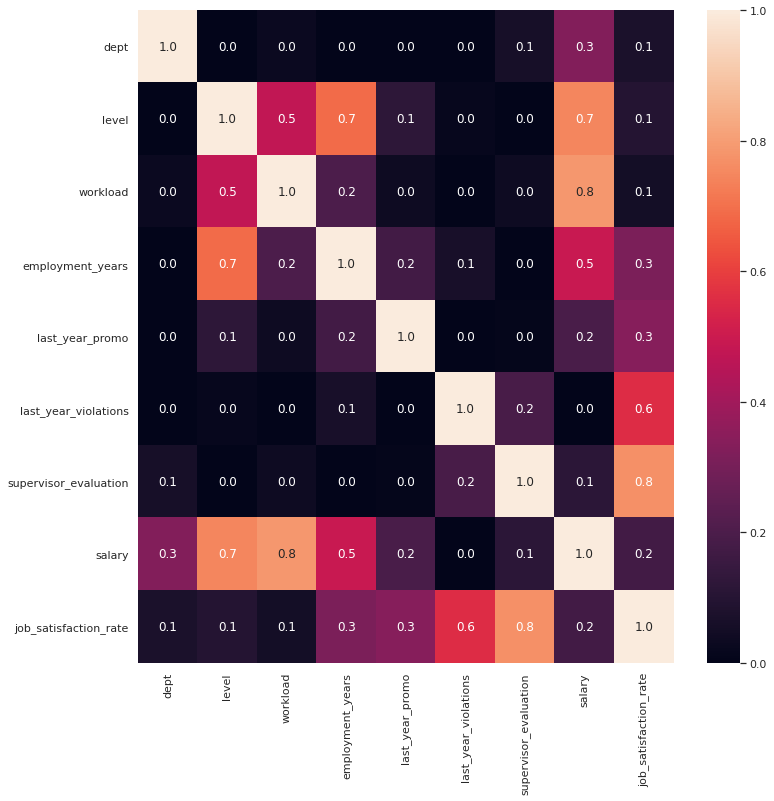

In [25]:
data_corr = data.drop('id', axis=1)
interval_cols= ['salary', 'job_satisfaction_rate']

sns.heatmap(data_corr.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.1f')
plt.show()

Судя по тепловой карте для тестовой выборки, аналогично, можем заметить, что целевой признак ***заметно*** коррелирует с нарушениями сотрудника за последний год, и ***высоко*** - с оценкой работника руководителем.

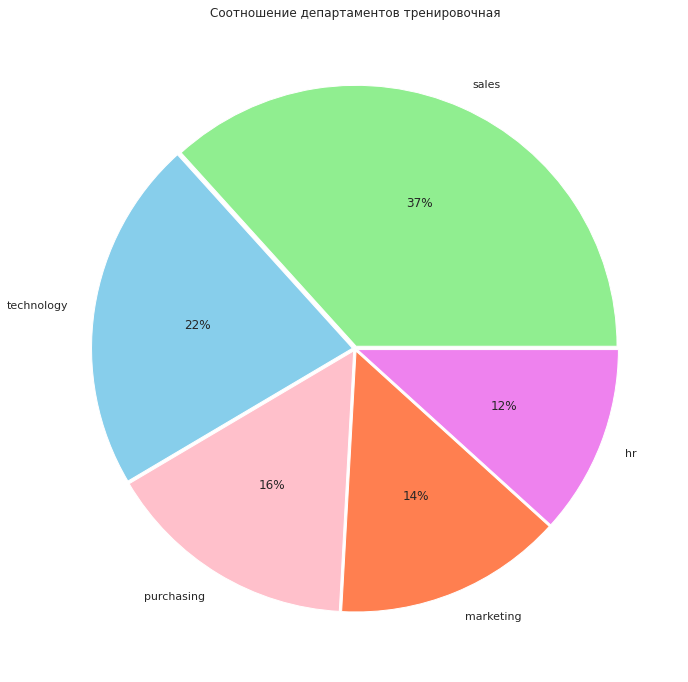

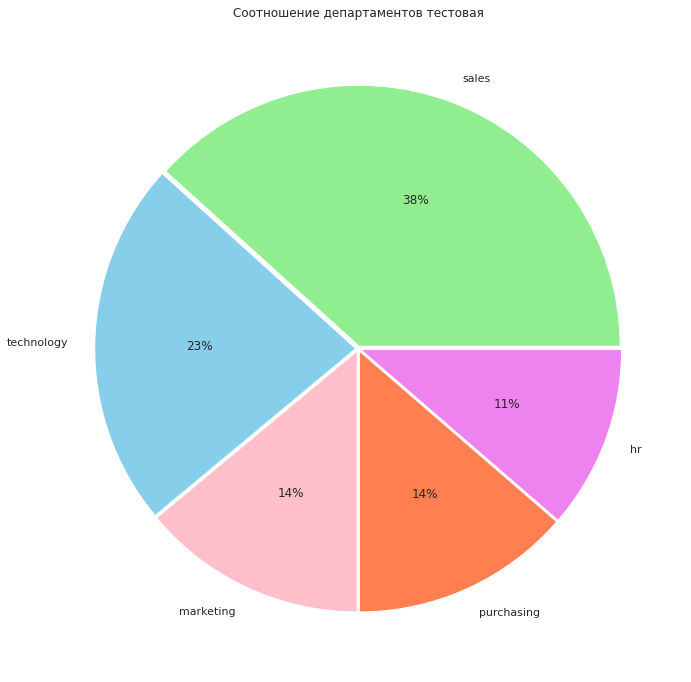

In [26]:
#fig, axes = plt.subplots(nrows=1, ncols=2)
colors = ['lightgreen', 'skyblue', 'pink', 'coral', 'violet'] 
explode = (0.01, 0.01, 0.01, 0.01, 0.01) 

X_train['dept'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение департаментов тренировочная', label='')
plt.show()
X_test['dept'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение департаментов тестовая', label='')
plt.show()

Видим, что распределение департаментов, в которых работают сотрудники, практически одинаковое.

Большинство работает в департаменте продаж, а меньшинство - в департаменте HR

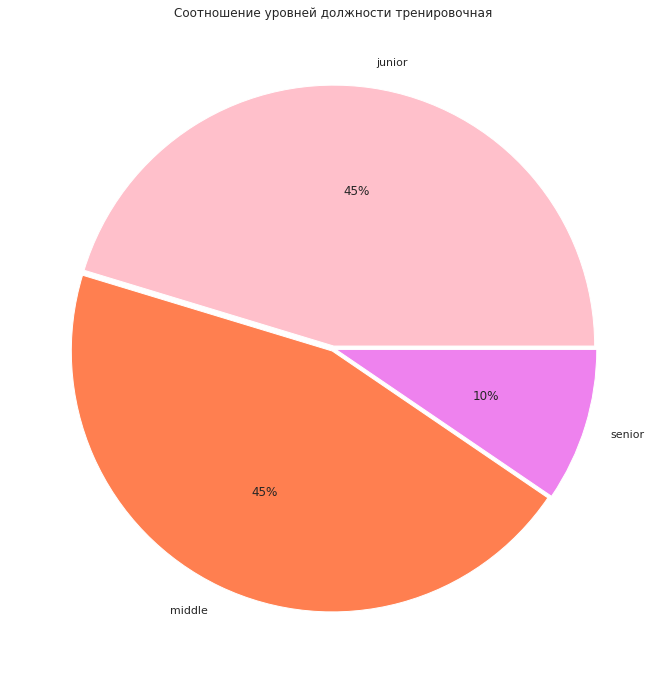

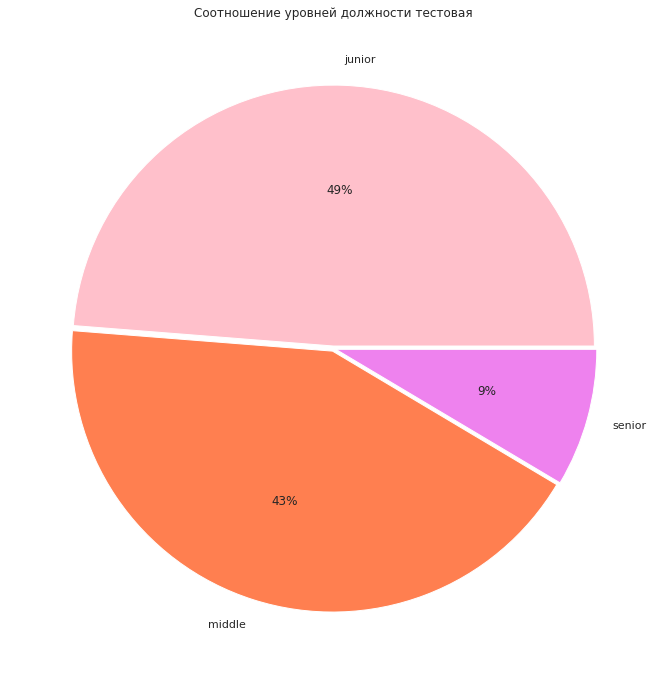

In [27]:
colors = ['pink', 'coral', 'violet'] 
explode = (0.01, 0.01, 0.01) 

X_train['level'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение уровней должности тренировочная', label='')
plt.show()
X_test['level'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение уровней должности тестовая', label='')
plt.show()

Аналогично, распределение уровней должностей в выборках примерно одинаковое.

Большинство сотрудников являются джуниорами, и всего 9% сениоров.

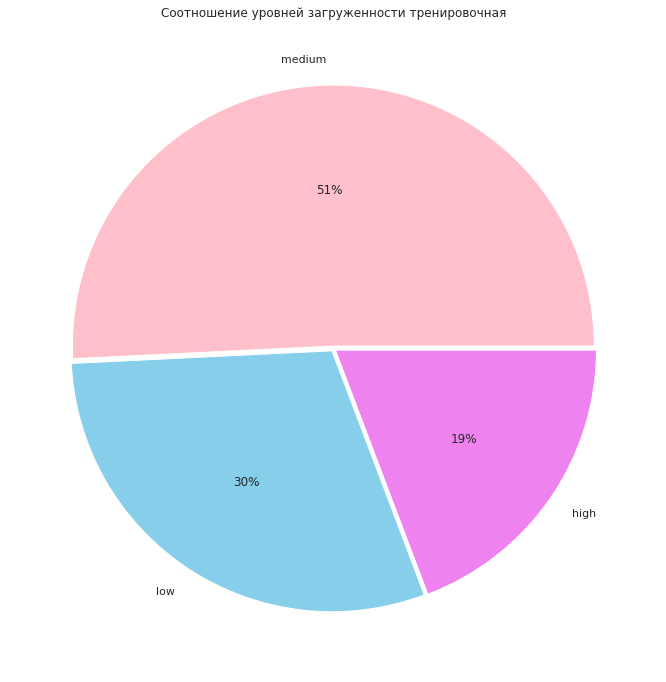

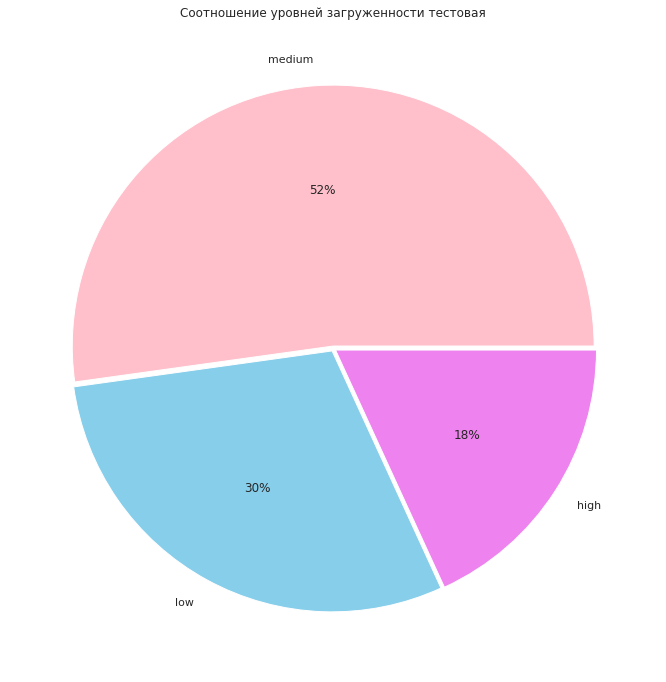

In [28]:
colors = ['pink', 'skyblue', 'violet'] 
explode = (0.01, 0.01, 0.01) 

X_train['workload'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение уровней загруженности тренировочная', label='')
plt.show()
X_test['workload'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение уровней загруженности тестовая', label='')
plt.show()

Загруженность сотрудников двух выборок одинаковая. В основном, загруженность средняя (52%).

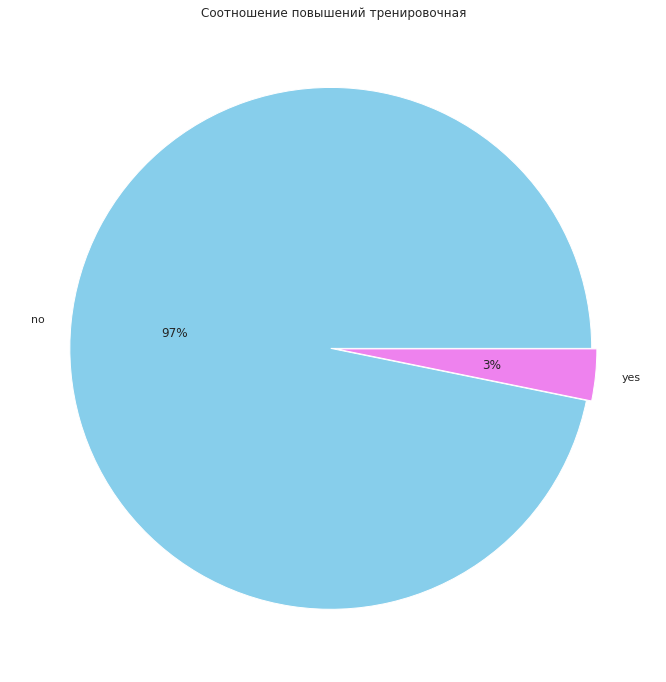

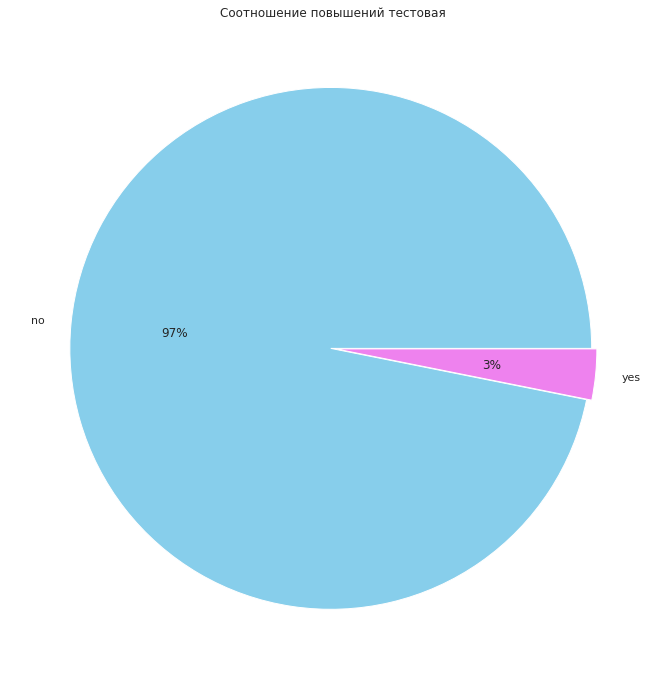

In [29]:
colors = ['skyblue', 'violet'] 
explode = (0.01, 0.01) 

X_train['last_year_promo'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение повышений тренировочная', label='')
plt.show()
X_test['last_year_promo'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение повышений тестовая', label='')
plt.show()

Распределения повышения сотрудников в двух выборках одинаковое.

Большинство сотрудников (97%) не получали повышение за последний год.

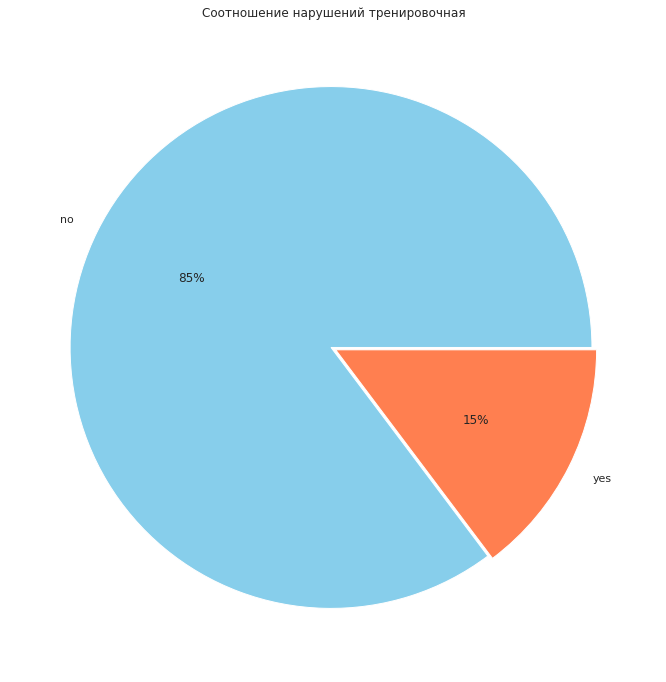

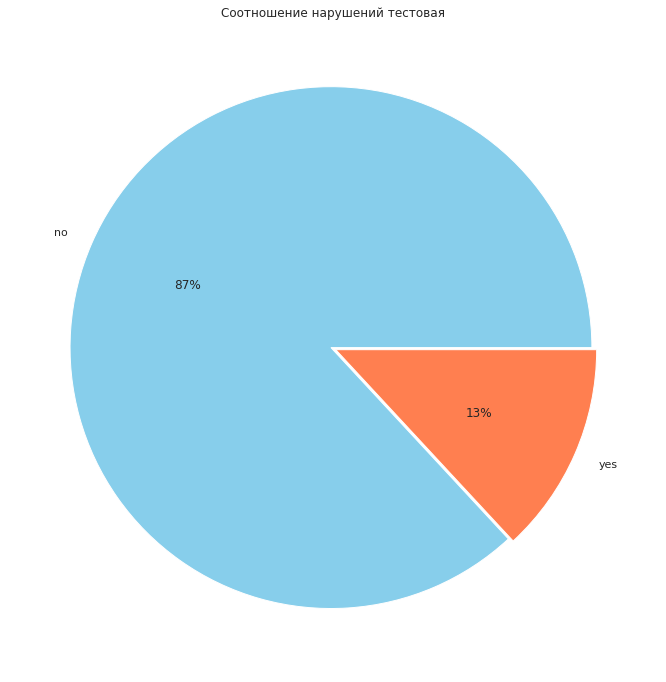

In [30]:
colors = ['skyblue', 'coral'] 
explode = (0.01, 0.01) 

X_train['last_year_violations'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение нарушений тренировочная', label='')
plt.show()
X_test['last_year_violations'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение нарушений тестовая', label='')
plt.show()

Соотношение нарушений сотрудников в двух выборках почти одинаковое.

Подавляющее большинство сотрудников (86% на тренировочной и 87% на тестовой) не нарушали трудовой договор.

Для построения модели нам нужно будем закодировать вышеперечисленные категориальные признаки. Сделаем это следующим образом:

- ***dept, last_year_promo, last_year_violations*** - с помощью OneHotEncoder

- ***level, workload*** - с помощью OrdinalEncoder

employment_years 



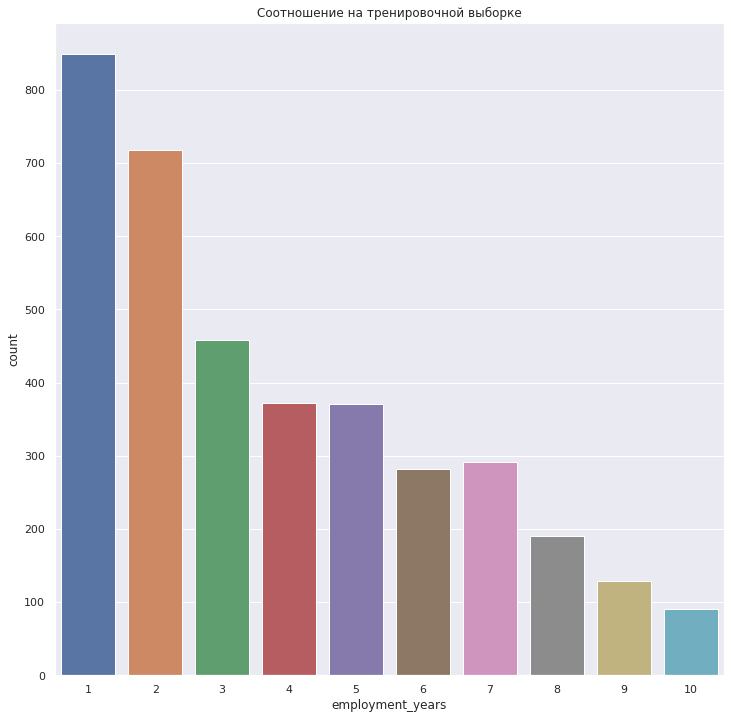

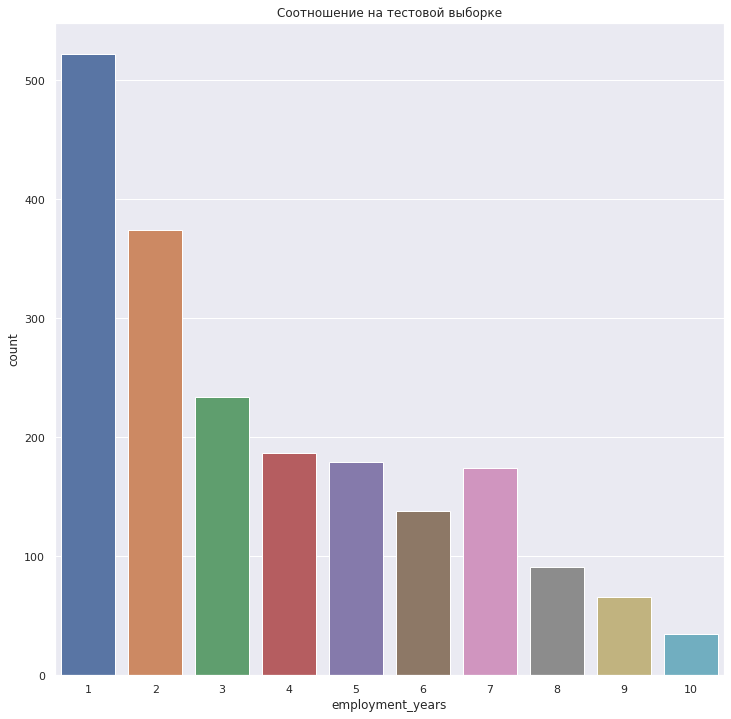

supervisor_evaluation 



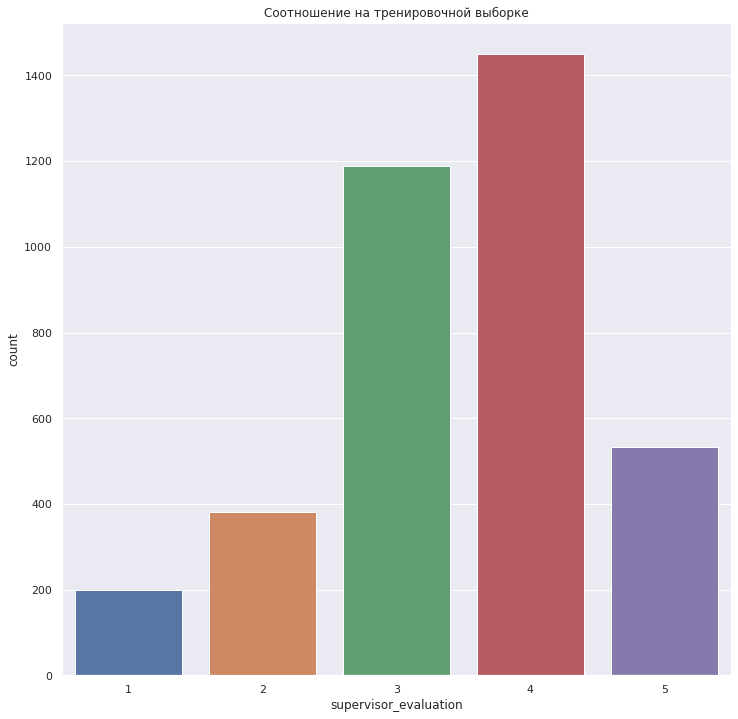

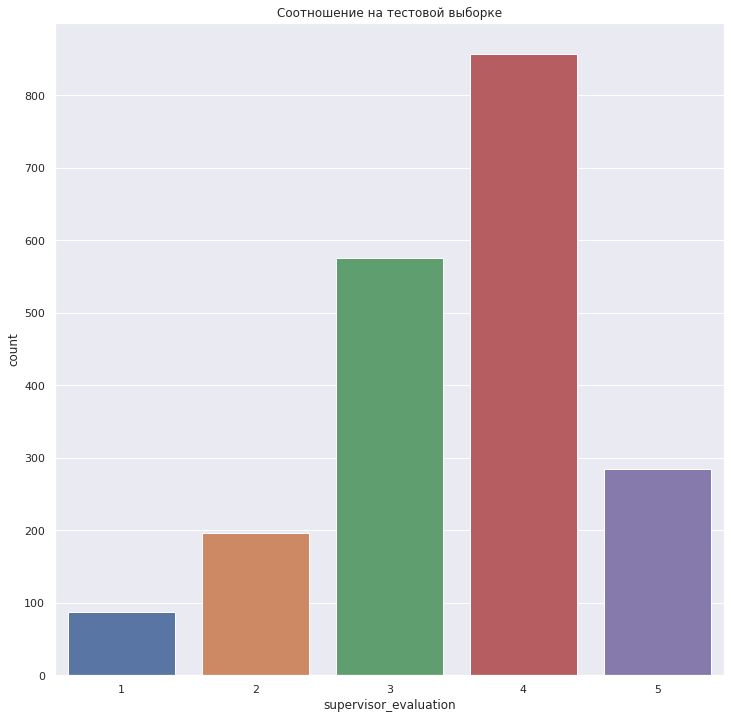

In [31]:
columns = ['employment_years', 'supervisor_evaluation']

for col in columns:
    print(col, '\n')
    sns.countplot(data=X_train, x=col)
    plt.title('Соотношение на тренировочной выборке')
    plt.show()
    sns.countplot(data=X_test, x=col)
    plt.title('Соотношение на тестовой выборке')
    plt.show()

salary 



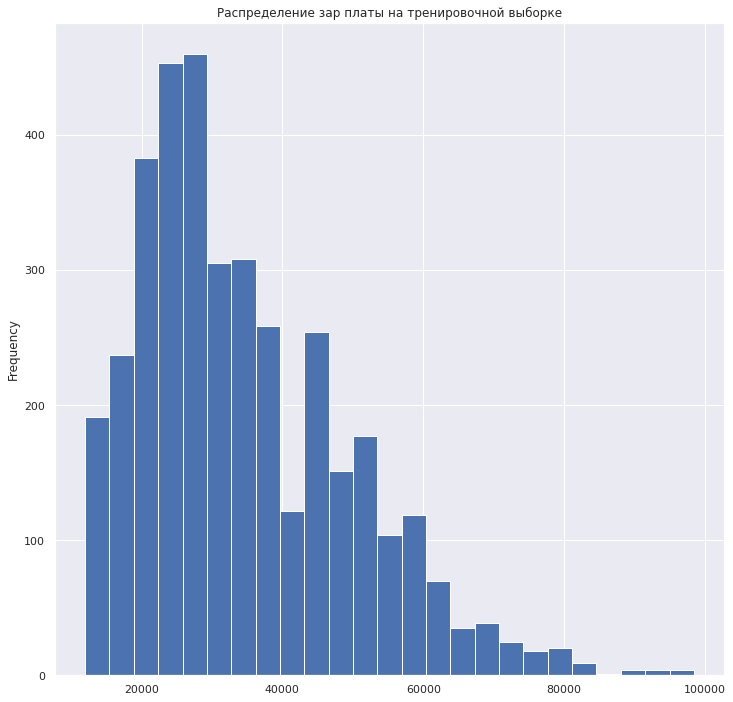

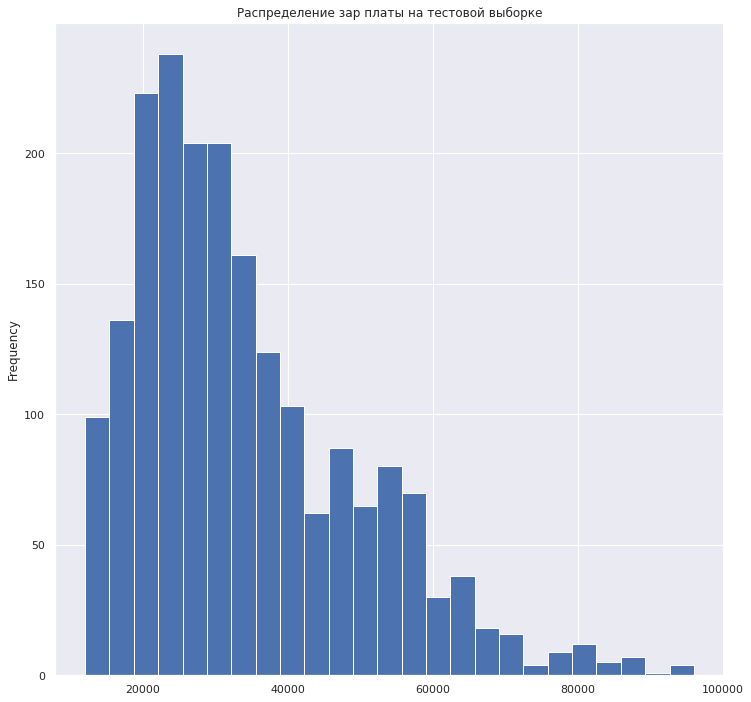

In [32]:
print('salary', '\n')
X_train['salary'].plot(kind='hist', bins=25)
plt.title('Распределение зар платы на тренировочной выборке')
plt.show()
X_test['salary'].plot(kind='hist', bins=25)
plt.title('Распределение зар платы на тестовой выборке')
plt.show()

Разложим все по полочкам:

1) Годы работы в компании

Видим, что большинство человек в обеих выборках работают в компании 1 год.

***
2) Оценки от руководителей

Оценки сотрудников руководителями распределены нормально в обоих случаях. В основном, сотрудники получают оценку 4 от руководителя.
***
3) Заработная плата

В обеих выборках, в основном, сотрудники получают от 22800 до 43200. В выборках есть выбросы, однако мы их тоже будем учитывать при работе с моделями.

Эти данные мы будет кодировать с помощью scaler для обучения модели.

**ВЫВОД:**

Мы провели исследовательский анализ данных, посмотрели на распределения каждого параметра в обеих выборках, поняли, как следует их кодировать или масштабировать для построения модели.

## Подготовка данных и обучение моделей 1

In [33]:
RANDOM_STATE=42

In [34]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [35]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)

In [36]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [37]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создание итогового пайплайна
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [38]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,12),
        'models__min_samples_split': range(2,12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [39]:
def smape(y_test, y_pred):
    return 100/len(y_test) * np.sum(np.abs(y_test-y_pred)/((np.abs(y_test) + np.abs(y_pred))/2))

scorer = make_scorer(smape, greater_is_better = False)

In [40]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid = param_grid, 
    cv = 5,
    scoring=scorer, 
    n_jobs=-1
)

In [41]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImput...
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(2, 12),
                          'models__min_samples_split': range(2, 12),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [42]:
y_pred = grid_search.predict(X_test)
score = smape(np.array(y_test), y_pred)
print ('Метрика лучшей модели при кросс-валидации:', (grid_search.best_score_)*(-1))

Метрика лучшей модели при кросс-валидации: 15.470265145613022


In [43]:
print(f'Метрика SMAPE на тестовой выборке: {score}')

Метрика SMAPE на тестовой выборке: 14.459648172947482


Можем увидеть, что метрика на тренировочной выборке равна 15, а на тестовой - 14.45. Модель работает удачно.

Проверим модель на адекватность с помощью DummyRegressor

In [44]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# оценка качества модели по метрике accuracy
dummy_smape = smape(y_test, dummy_model_preds)
print('Model smape =', round(dummy_smape, 2))

Model smape = 38.26


Как видим, метрика smape на тестовых данных с такой моделью работает хуже. Значит, работа с моделью была проделана не зря)

## Вывод по задаче 1

Лучше всего справилась модель дерева решений DecisionTreeRegressor(max_depth=11, min_samples_split=6, random_state=42). 

## Загрузка данных 2

In [45]:
train_quit = pd.read_csv('/datasets/train_quit.csv', sep=',')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [46]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [47]:
test_features = pd.read_csv('/datasets/test_features.csv', sep=',')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [48]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [49]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv', sep=',')
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [50]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


## Предобработка данных 2

In [51]:
train_quit.duplicated().sum() #проверка на явные

0

In [52]:
test_features.duplicated().sum()

0

In [53]:
test_target_quit.duplicated().sum()

0

In [54]:
print(train_quit['dept'].unique(), '\n') #проверка на неявные дубли
print(test_features['dept'].unique(), '\n')
print(train_quit['level'].unique(), '\n') 
print(test_features['level'].unique(), '\n')
print(train_quit['workload'].unique(), '\n') 
print(test_features['workload'].unique(), '\n')
print(train_quit['last_year_promo'].unique(), '\n') 
print(test_features['last_year_promo'].unique(), '\n')
print(train_quit['last_year_violations'].unique(), '\n') 
print(test_features['last_year_violations'].unique(), '\n')

['sales' 'purchasing' 'marketing' 'technology' 'hr'] 

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 

['middle' 'junior' 'sinior'] 

['junior' 'middle' 'sinior' nan] 

['high' 'medium' 'low'] 

['medium' 'low' 'high' ' '] 

['no' 'yes'] 

['no' 'yes'] 

['no' 'yes'] 

['no' 'yes'] 



In [55]:
test_features['level'] = test_features['level'].replace('sinior', 'senior')
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [56]:
data_1 = test_features.merge(test_target_quit, on='id', how='inner')
data_1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


In [57]:
data_1['dept'] = data_1['dept'].replace(' ', np.nan)
data_1['workload'] = data_1['workload'].replace(' ', np.nan)

In [58]:
imputer_pipe =  Pipeline([('simpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]) #pipe для пропусков
imputer_col = ['dept', 'level', 'workload']
train_quit[imputer_col] = imputer_pipe.fit_transform(train_quit[imputer_col])
data_1[imputer_col] = imputer_pipe.transform(data_1[imputer_col])
data_1['workload'].unique() #проверка

array(['medium', 'low', 'high'], dtype=object)

## Исследовательский анализ данных 2

**1) Исследовательский анализ** 

In [59]:
X_train_1 = train_quit.drop('id', axis=1) #убираем новые возможные явные дубли
X_train_1 = X_train_1.drop('quit', axis=1)
X_train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 250.1+ KB


In [60]:
X_test_1 = data_1.drop(['id', 'quit'],axis=1)
y_test_1 = data_1['quit']
y_train_1 = train_quit['quit']

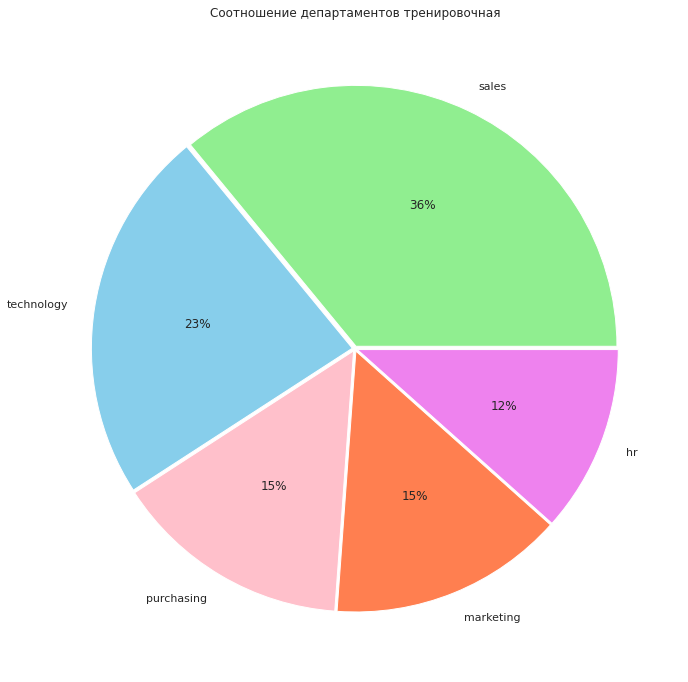

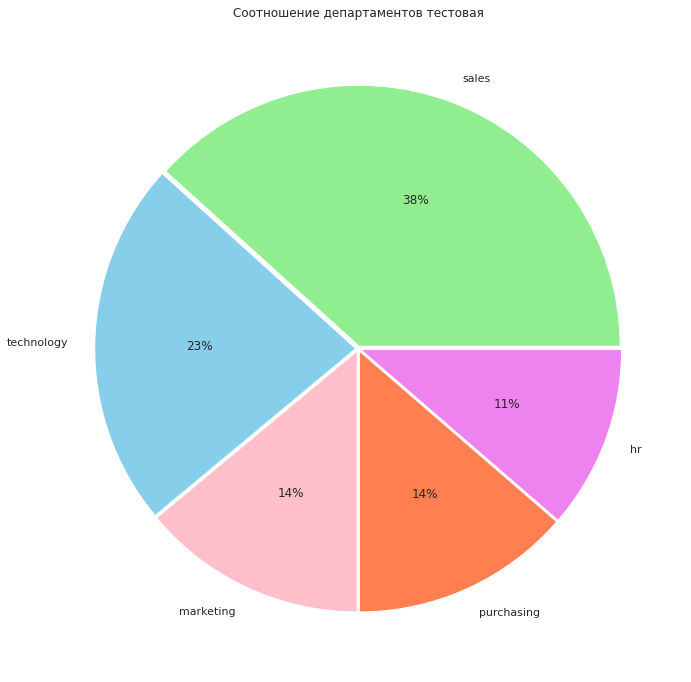

In [61]:
#fig, axes = plt.subplots(nrows=1, ncols=2)
colors = ['lightgreen', 'skyblue', 'pink', 'coral', 'violet'] 
explode = (0.01, 0.01, 0.01, 0.01, 0.01) 

X_train_1['dept'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение департаментов тренировочная', label='')
plt.show()
X_test_1['dept'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение департаментов тестовая', label='')
plt.show()

Видим, что в обеих выборках сотрудники работают в большинстве своем в отделе продаж.

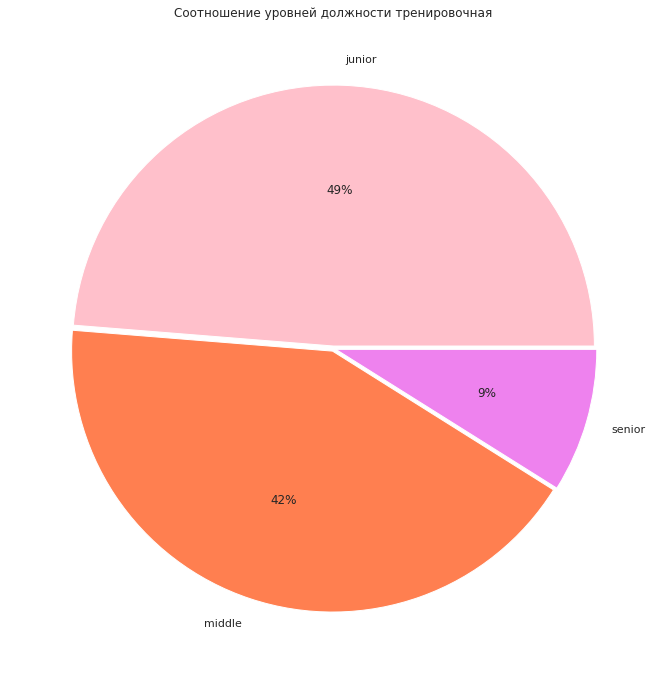

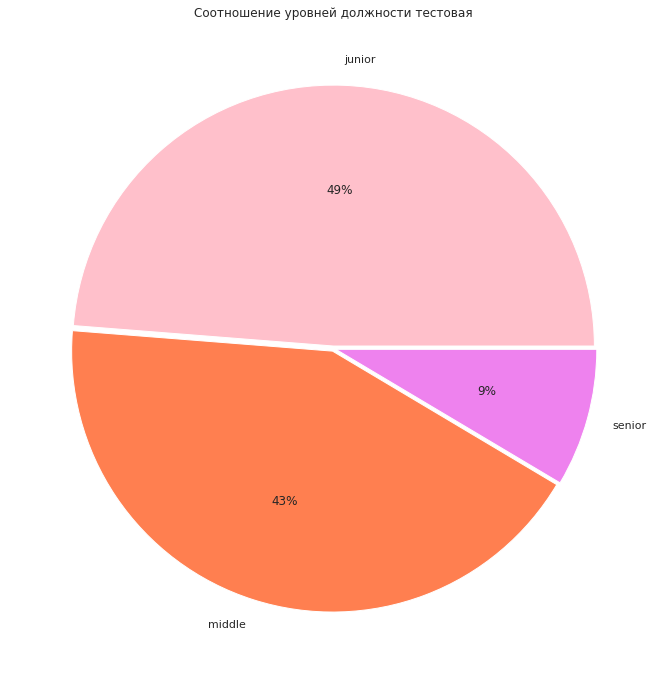

In [62]:
colors = ['pink', 'coral', 'violet'] 
explode = (0.01, 0.01, 0.01) 

X_train_1['level'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение уровней должности тренировочная', label='')
plt.show()
X_test_1['level'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение уровней должности тестовая', label='')
plt.show()

Уровни должностей распределены одинаково в тренировочной и в тестовой выборке. 

В основном, это junior и middle.

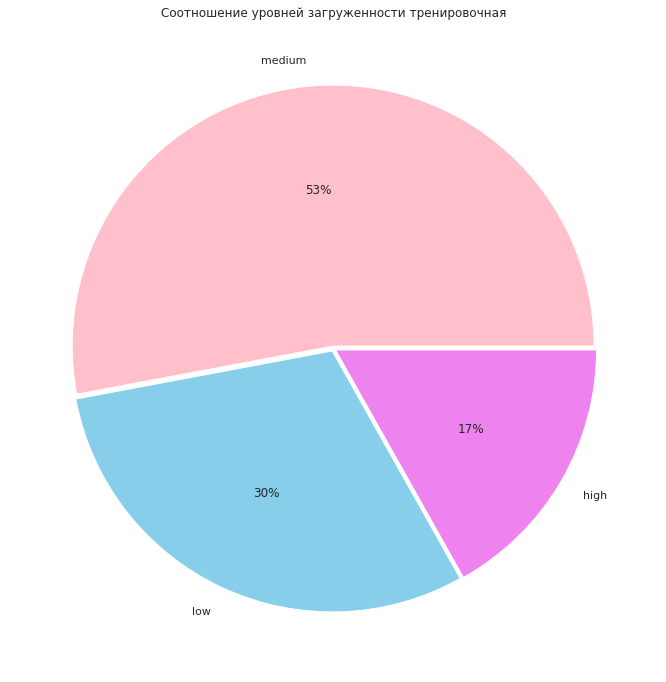

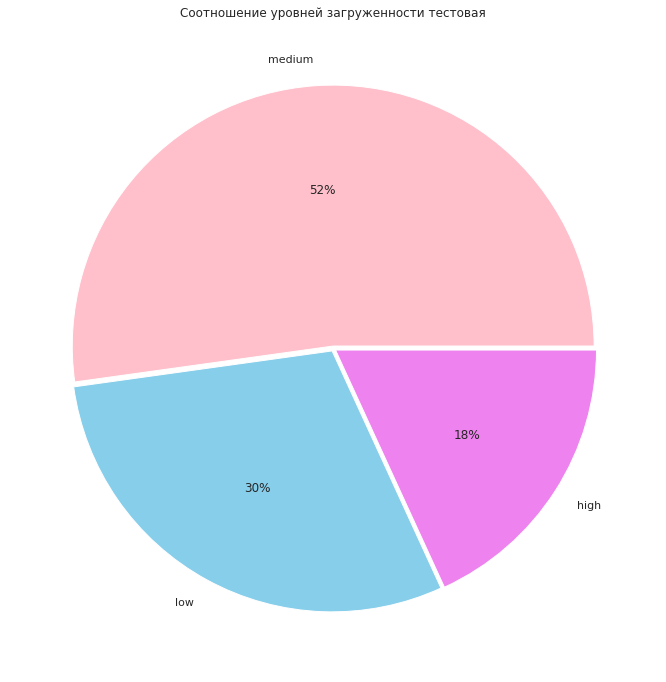

In [63]:
colors = ['pink', 'skyblue', 'violet'] 
explode = (0.01, 0.01, 0.01) 

X_train_1['workload'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение уровней загруженности тренировочная', label='')
plt.show()
X_test_1['workload'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение уровней загруженности тестовая', label='')
plt.show()

У половины сотрудников в обеих выборках загруженность на работе средняя.

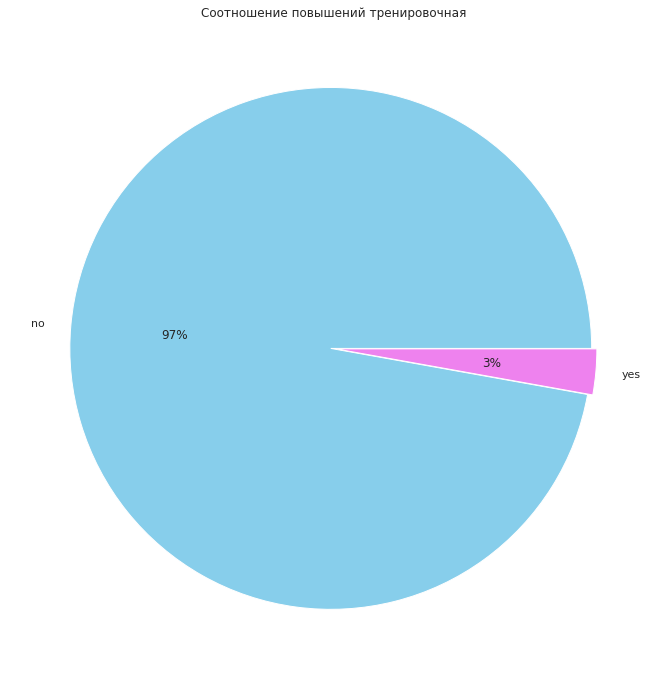

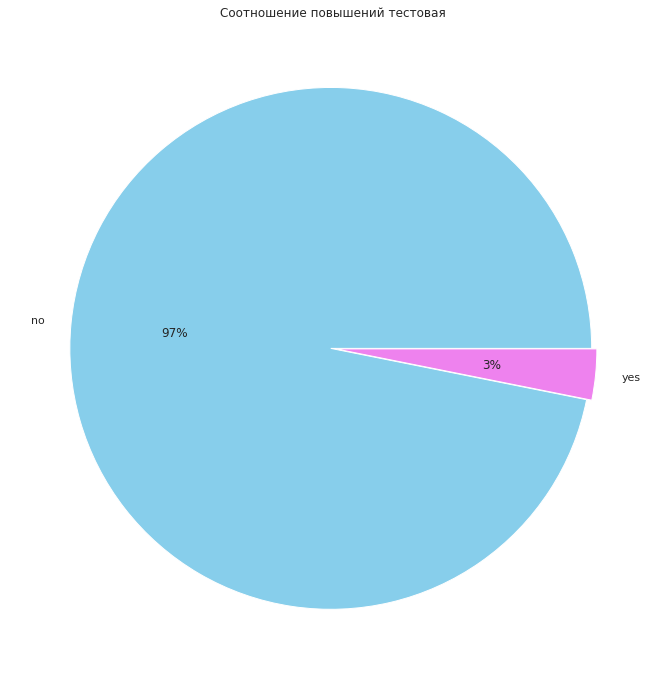

In [64]:
colors = ['skyblue', 'violet'] 
explode = (0.01, 0.01) 

X_train_1['last_year_promo'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение повышений тренировочная', label='')
plt.show()
X_test_1['last_year_promo'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение повышений тестовая', label='')
plt.show()

У подавляющего большинства сотрудников (97% в обеих выборках) повышений за год не наблюдалось.

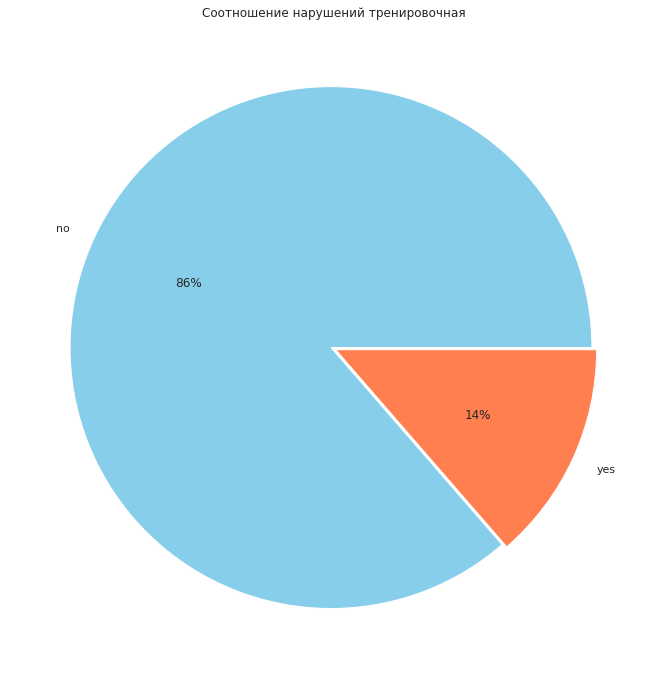

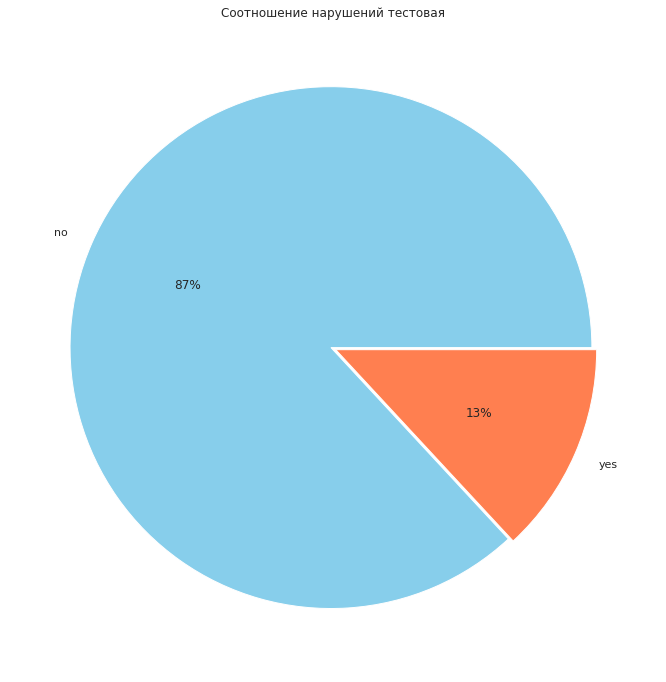

In [65]:
colors = ['skyblue', 'coral'] 
explode = (0.01, 0.01) 

X_train_1['last_year_violations'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение нарушений тренировочная', label='')
plt.show()
X_test_1['last_year_violations'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение нарушений тестовая', label='')
plt.show()

В обеих выборках большинство сотрудников (86% в тренировочной и 87% в тестовой) не нарушали трудовой договор.

employment_years 



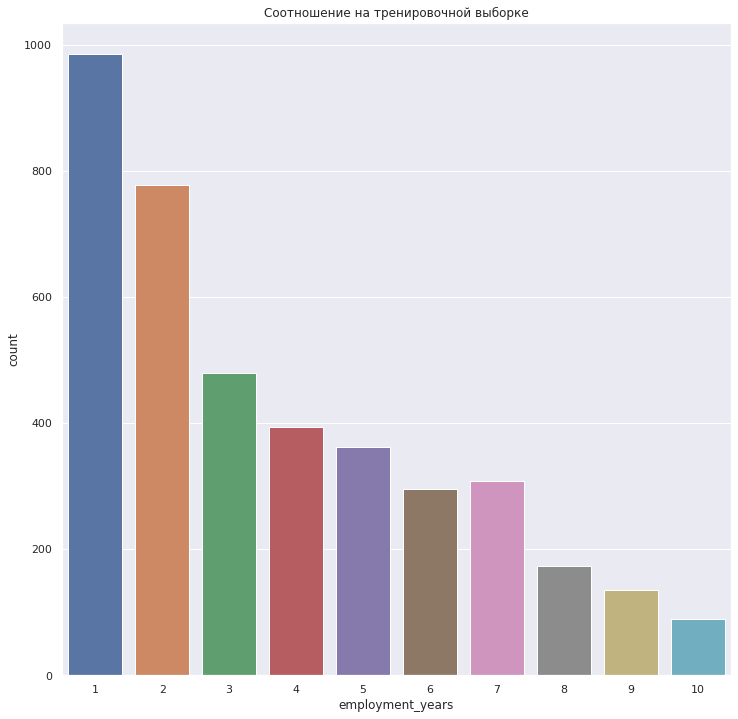

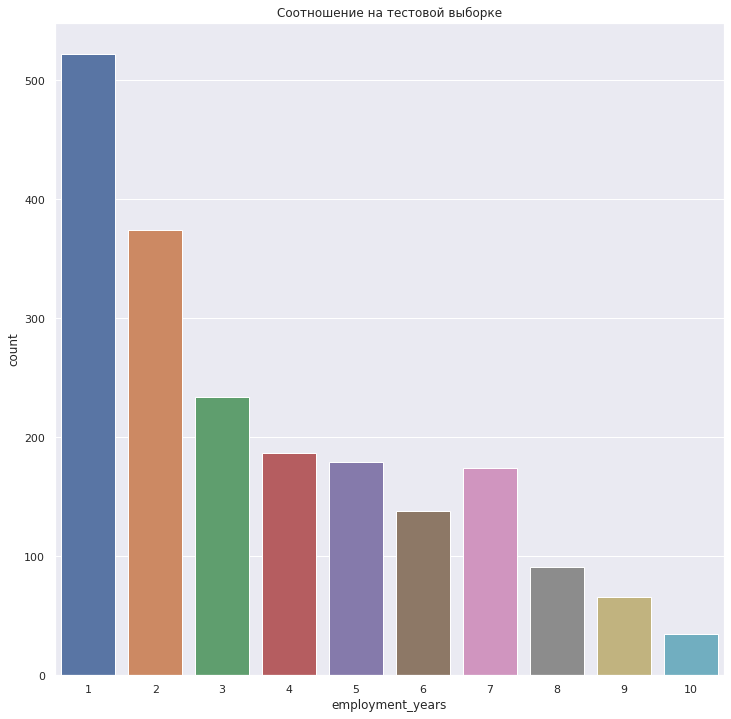

supervisor_evaluation 



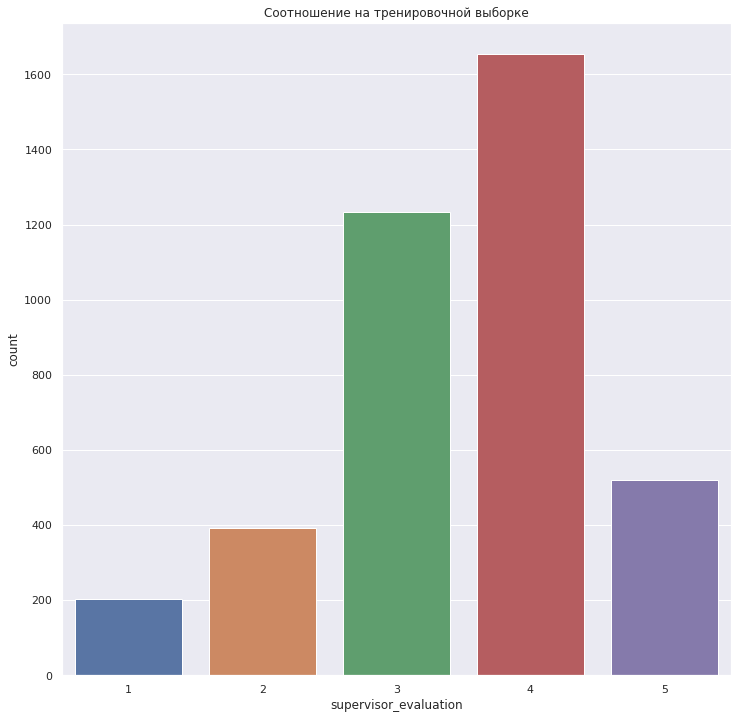

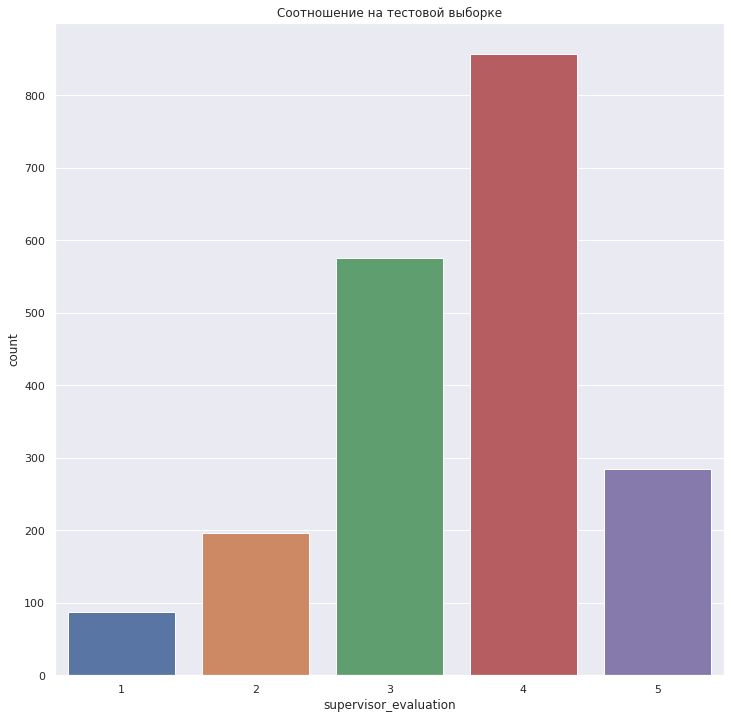

In [66]:
columns = ['employment_years', 'supervisor_evaluation']

for col in columns:
    print(col, '\n')
    sns.countplot(data=X_train_1, x=col)
    plt.title('Соотношение на тренировочной выборке')
    plt.show()
    sns.countplot(data=X_test_1, x=col)
    plt.title('Соотношение на тестовой выборке')
    plt.show()

salary 



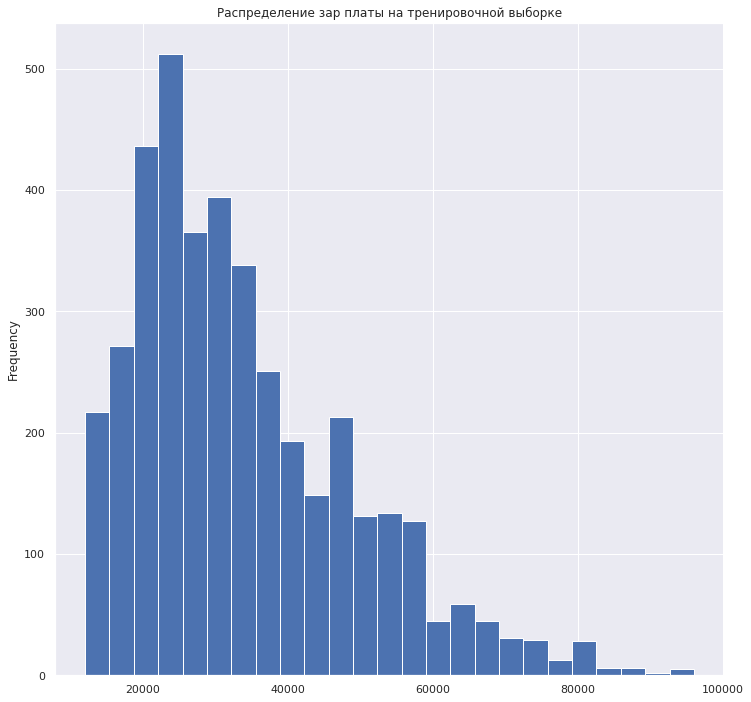

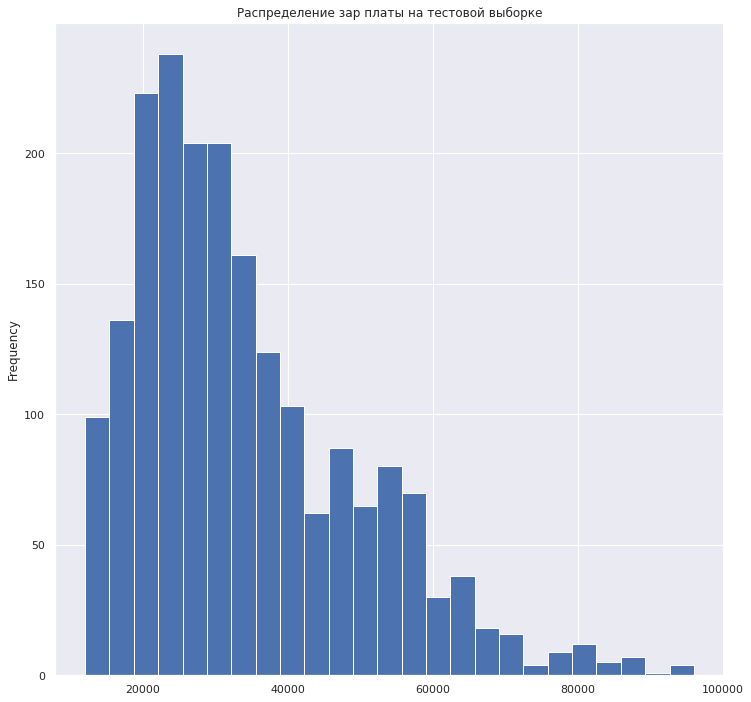

In [67]:
print('salary', '\n')
X_train_1['salary'].plot(kind='hist', bins=25)
plt.title('Распределение зар платы на тренировочной выборке')
plt.show()
X_test_1['salary'].plot(kind='hist', bins=25)
plt.title('Распределение зар платы на тестовой выборке')
plt.show()

1) Годы работы в компании

Видим, что также большинство человек в обеих выборках работают в компании от 2 до 6 лет.
***
2) Оценки от руководителей

Оценки сотрудников руководителями распределены нормально в обоих случаях. В основном, сотрудники получают оценки 3 и 4, но 1 - тоже бывает.
***
3) Заработная плата

В обеих выборках, в основном, сотрудники получают от 22800 до 43200. Во второй выборке есть выбросы, однако мы их тоже будем учитывать при работе с моделями.

Посмотрим на корреляцию признаков в новой тренировочной и тестовой выборке 

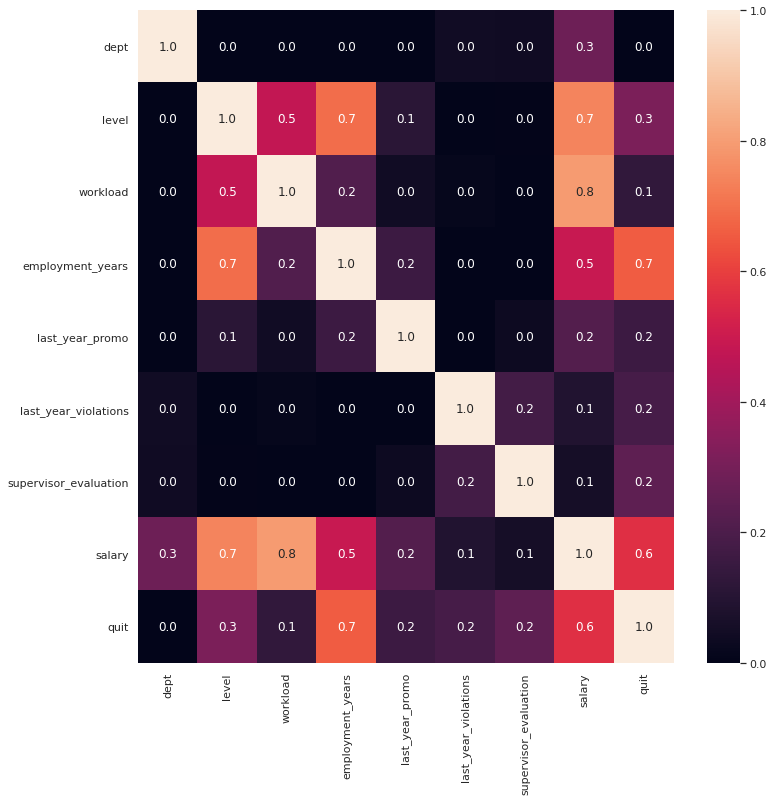

In [68]:
sns.set_theme(rc={'figure.figsize':(12,12)})
quit_corr_train = train_quit.drop('id', axis=1)
interval_cols= ['salary']

sns.heatmap(quit_corr_train.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.1f')
plt.show()

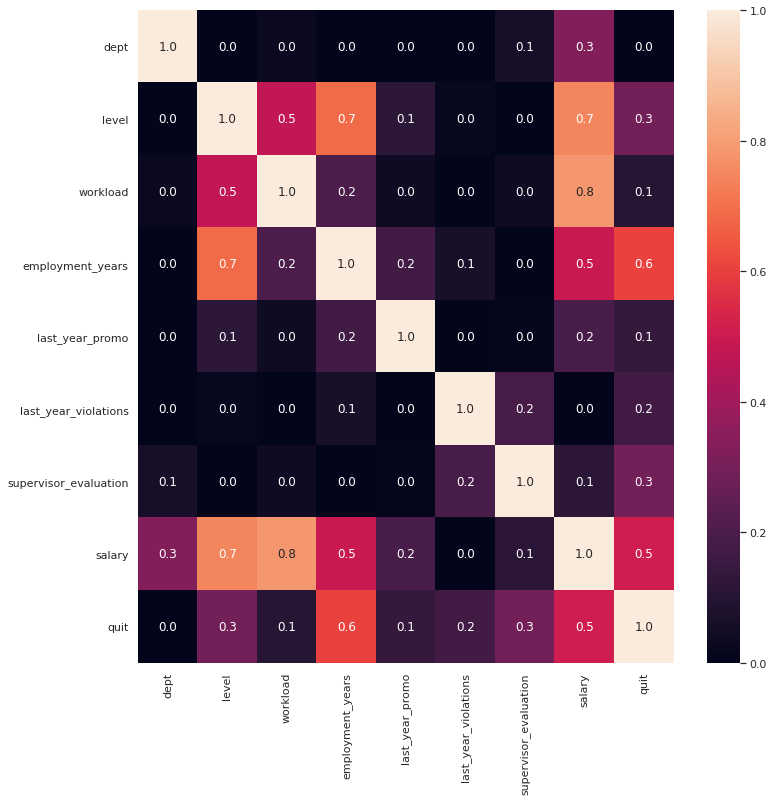

In [69]:
sns.set_theme(rc={'figure.figsize':(12,12)})
quit_corr_train_1 = data_1.drop('id', axis=1)
interval_cols= ['salary']

sns.heatmap(quit_corr_train_1.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.1f')
plt.show()

Как мы видим, в новых выборках целевой признак (увольнение) ***заметно*** коррелирует с стажем работы в компании и заработной платой

**2) Портрет уволившегося сотрудника**

In [70]:
portret_quit = train_quit.query('quit == "yes"')
portret_no_quit = train_quit.query('quit == "no"')
portret_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128 entries, 3 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     1128 non-null   int64 
 1   dept                   1128 non-null   object
 2   level                  1128 non-null   object
 3   workload               1128 non-null   object
 4   employment_years       1128 non-null   int64 
 5   last_year_promo        1128 non-null   object
 6   last_year_violations   1128 non-null   object
 7   supervisor_evaluation  1128 non-null   int64 
 8   salary                 1128 non-null   int64 
 9   quit                   1128 non-null   object
dtypes: int64(4), object(6)
memory usage: 96.9+ KB


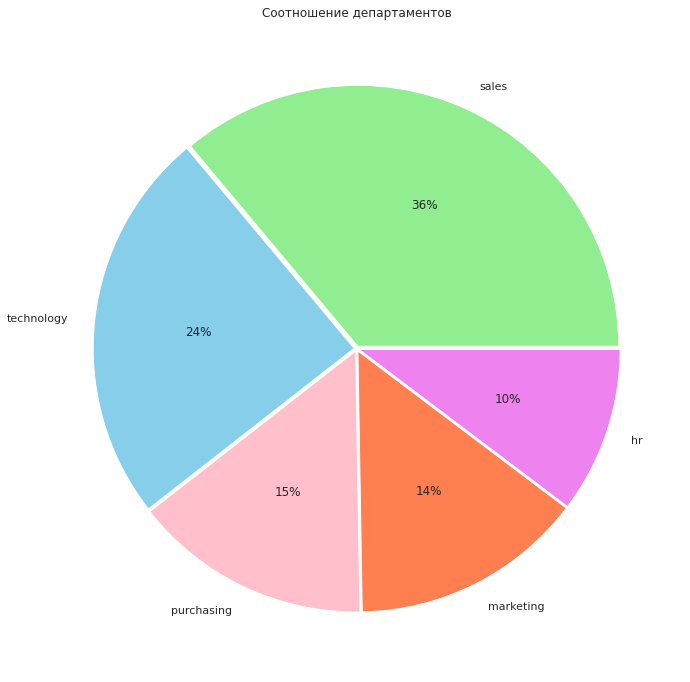

In [71]:
colors = ['lightgreen', 'skyblue', 'pink', 'coral', 'violet'] 
explode = (0.01, 0.01, 0.01, 0.01, 0.01) 

portret_quit['dept'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение департаментов', label='')
plt.show()

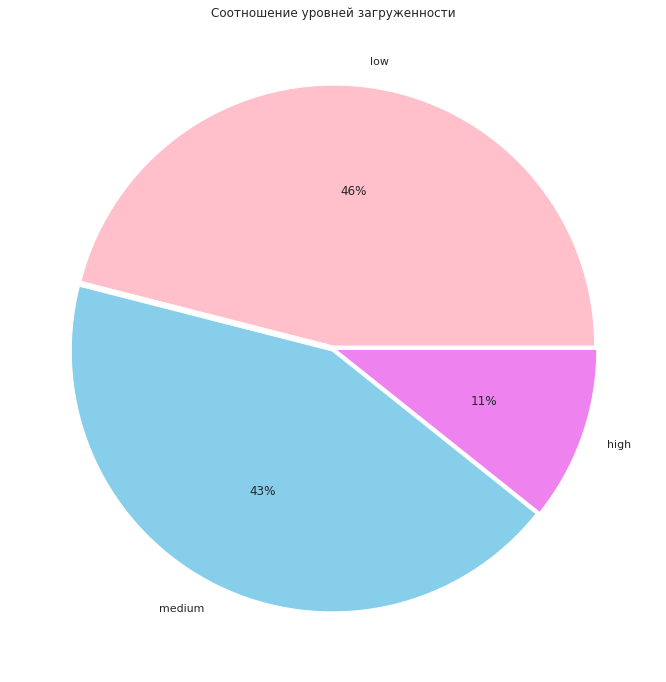

In [72]:
colors = ['pink', 'skyblue', 'violet'] 
explode = (0.01, 0.01, 0.01) 

portret_quit['workload'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение уровней загруженности', label='')
plt.show()

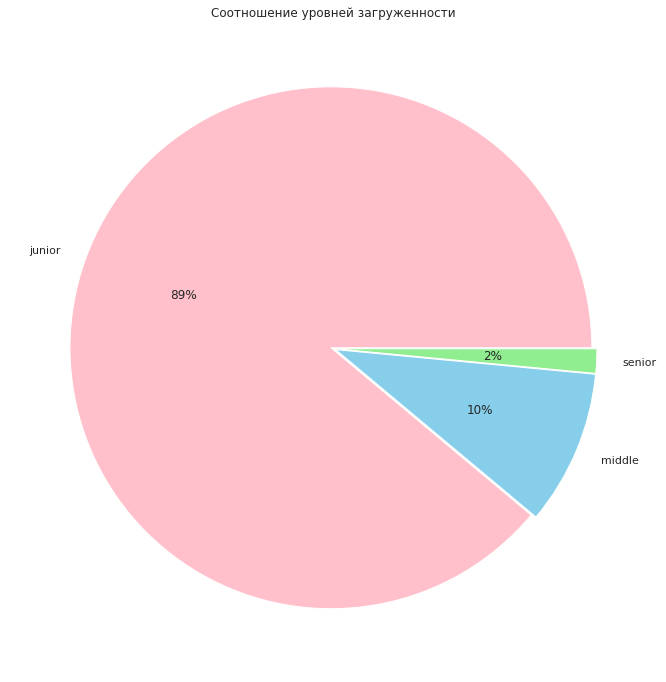

In [73]:
colors = ['pink', 'skyblue', 'lightgreen'] 
explode = (0.01, 0.01, 0.01) 

portret_quit['level'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение уровней загруженности', label='')
plt.show()

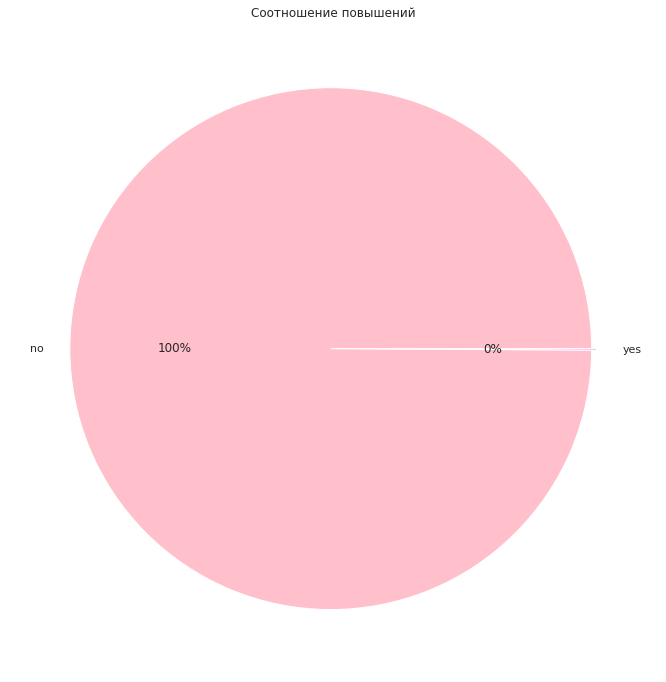

In [74]:
colors = ['pink', 'violet'] 
explode = (0.01, 0.01) 

portret_quit['last_year_promo'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение повышений', label='')
plt.show()

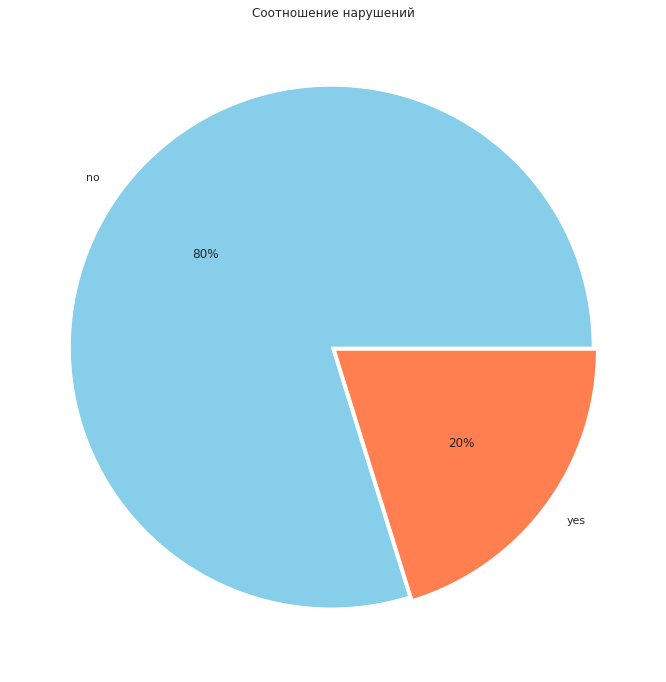

In [75]:
colors = ['skyblue', 'coral'] 
explode = (0.01, 0.01) 

portret_quit['last_year_violations'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение нарушений', label='')
plt.show()

In [76]:
def sanction(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    else:
        return 'Другой стаж'
    
portret_quit['employment_years'] = portret_quit['employment_years'].apply(sanction)
portret_quit['employment_years'].unique()

/tmp/ipykernel_102/1694653797.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portret_quit['employment_years'] = portret_quit['employment_years'].apply(sanction)


array([2, 1, 3, 'Другой стаж'], dtype=object)

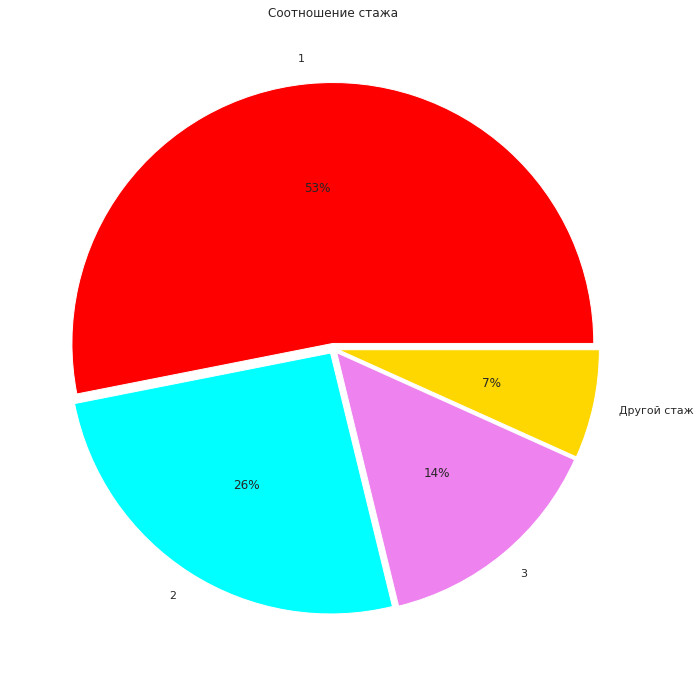

In [77]:
colors = ['red', 'aqua', 'violet', 'gold'] 
explode = (0.02, 0.02, 0.02, 0.02) 

portret_quit['employment_years'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение стажа', label='')
plt.show()

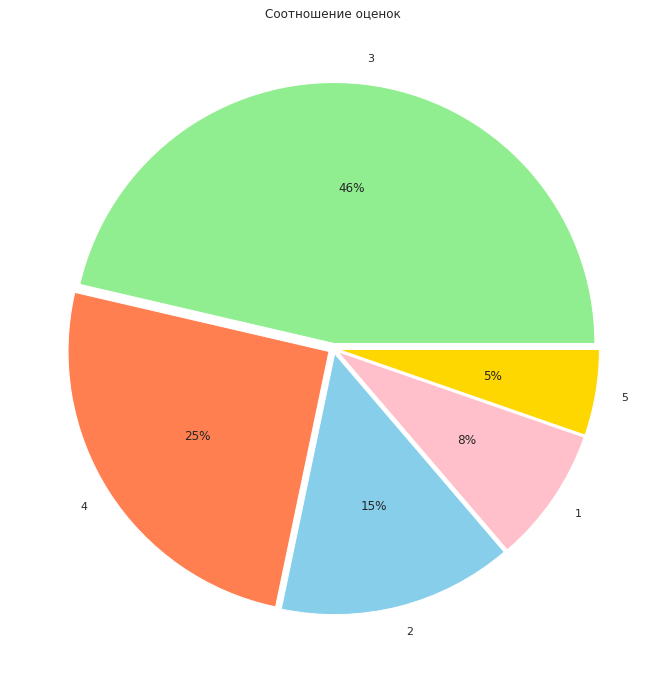

In [78]:
colors = ['lightgreen', 'coral', 'skyblue', 'pink','gold'] 
explode = (0.02, 0.02, 0.02, 0.02, 0.02) 

portret_quit['supervisor_evaluation'].value_counts().plot(kind='pie',autopct='%1.0f%%', colors=colors, explode=explode, title='Соотношение оценок', label='')
plt.show()

In [79]:
print('Распределение заработной платы у уволившихся сотрудников')
portret_quit['salary'].describe()

Распределение заработной платы у уволившихся сотрудников


count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

In [80]:
print('Распределение заработной платы у оставшихся сотрудников')
portret_no_quit['salary'].describe()

Распределение заработной платы у оставшихся сотрудников


count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

**Итоговый портрет:**

- Уволившиеся сотрудники с большей вероятностью работали в отделе продаж.

- Уволившиеся сотрудники, скорее, имели малый уровень загруженности и являлись джуниорами.

- 80% из них не нарушали договор.

- Все уволившиеся сотрудники не получали повышений за год.

- В основном, они получали 3 от руководителей.

- Работали, в основном, 1-2 года.

- Уволившиеся сотрудники получали, в среднем, меньше (25000), чем оставшиеся (37000).

**3) Связь удовлетворенности работой и увольнением**

In [81]:
quit_satisfaction = data_1.merge(goal_test, on='id', how='inner') 
quit_satisfaction = quit_satisfaction.query('quit == "yes"')
quit_satisfaction['job_satisfaction_rate'].describe()

count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64

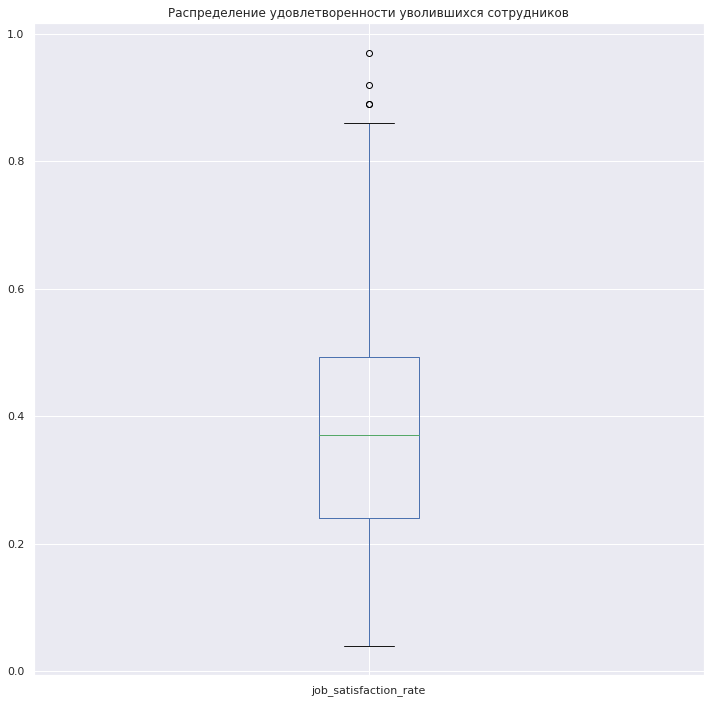

In [82]:
quit_satisfaction['job_satisfaction_rate'].plot(kind='box')
plt.title('Распределение удовлетворенности уволившихся сотрудников')
plt.show()

Те сотрудники, которые увольняются, ставят заметно низкие оценки. В основном, они от 0.24 до 0.5.

In [83]:
quit_no_satisfaction = data_1.merge(goal_test, on='id', how='inner') 
quit_no_satisfaction = quit_no_satisfaction.query('quit == "no"')
quit_no_satisfaction['job_satisfaction_rate'].describe()

count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

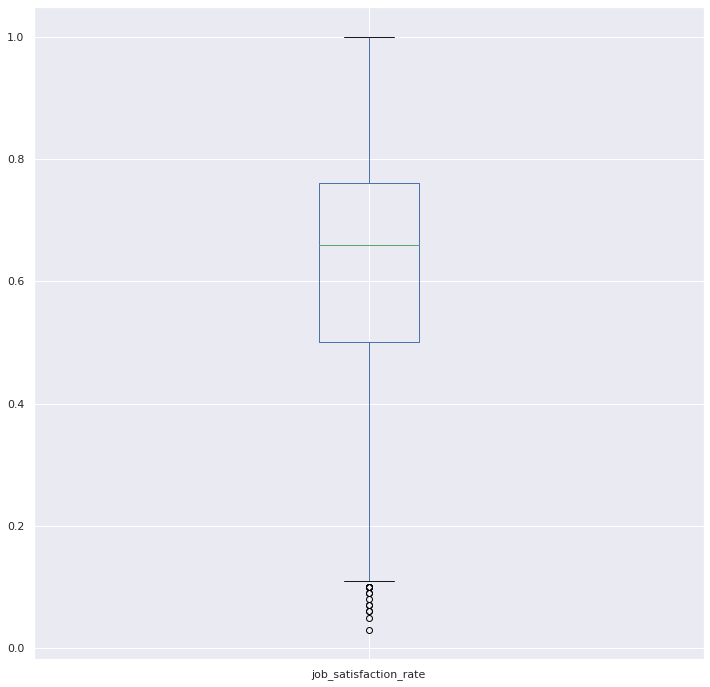

In [84]:
quit_no_satisfaction['job_satisfaction_rate'].plot(kind='box')
plt.show()

А сотрудники, которые решают остаться, как раз удовлетворены своей работой, и ставят оценки от 0.5 до почти 0.8!

Проверим с помощью тепловой карты, есть ли действительно связь между признаками.

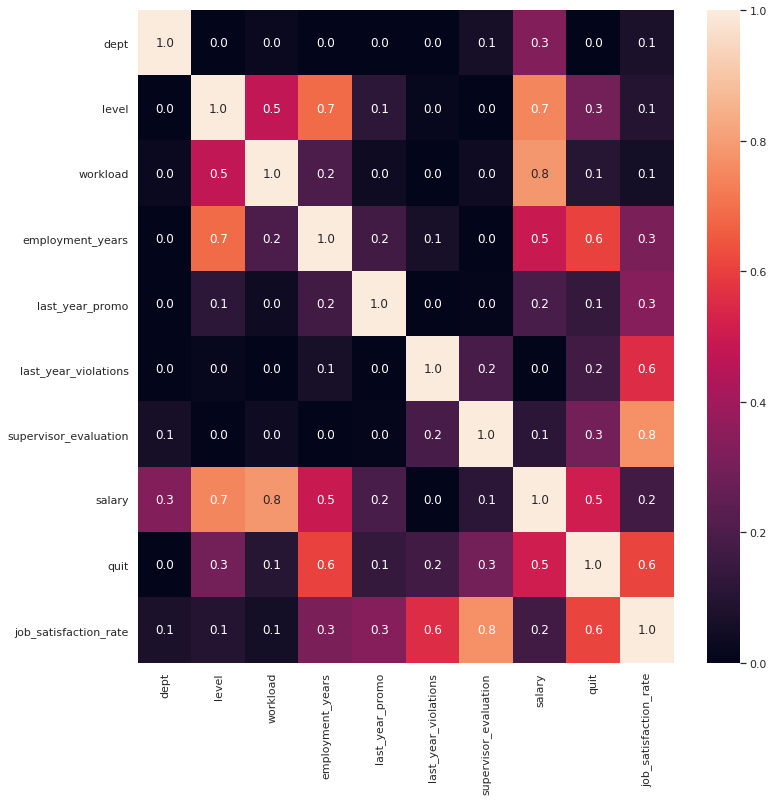

<Figure size 7200x7200 with 0 Axes>

In [85]:
corr = data_1.merge(goal_test, on='id', how='inner')
corr_1 = corr.drop('id', axis=1)
interval_cols= [
   'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'
]

sns.heatmap(corr_1.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.1f')
plt.figure(figsize=(100,100))
plt.show()

Действительно, видна ***заметная*** связь между увольнением и удовлетворенностью работой.

## Добавление входного признака

In [86]:
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']
clf = grid_search.best_estimator_.named_steps['models']
X_train_2 = preprocessor.transform(X_train_1)
X_test_2 = preprocessor.transform(X_test_1)

y_train_pred = clf.predict(X_train_2)
y_test_pred = clf.predict(X_test_2)

In [87]:
X_train_1['job_satisfaction_rate'] = y_train_pred
X_test_1['job_satisfaction_rate'] = y_test_pred

X_train_1

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.638070
1,sales,junior,medium,2,no,no,4,27600,0.839155
2,purchasing,middle,medium,5,no,no,1,37200,0.369167
3,sales,junior,medium,2,no,yes,3,24000,0.340000
4,marketing,junior,medium,2,no,no,5,25200,0.797857
...,...,...,...,...,...,...,...,...,...
3995,sales,junior,medium,4,no,no,3,26400,0.525385
3996,sales,middle,high,9,no,no,4,52800,0.804444
3997,purchasing,junior,low,2,no,yes,4,12000,0.546667
3998,purchasing,middle,medium,2,no,no,4,33600,0.493704


## Подготовка данных и обучение моделей 2

In [88]:
ohe_columns_1 = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns_1 = ['level', 'workload']

num_columns_1 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# обучаем модель и трансформируем тренировочную выборку 
y_train_1 = label_encoder.fit_transform(y_train_1)

# трансформируем тестовую выборку
y_test_1 = label_encoder.transform(y_test_1)

In [89]:
data_preprocessor_1 = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns_1),
     ('ord', ord_pipe, ord_columns_1),
     ('num', MinMaxScaler(), num_columns_1)
    ], 
    remainder='passthrough'
)

# создание итогового пайплайна
pipe_final_1 = Pipeline(
    [
        ('preprocessor', data_preprocessor_1),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [90]:
param_dis_1 = [
     # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,9),
        'models__max_features': range(2,9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }, 
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty = 'l1'
        )],
        'models__C': np.arange(0.01, 5, 0.1),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }, 
     # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    }
]

In [91]:
randomized_search_1 = RandomizedSearchCV(
    pipe_final_1, 
    param_distributions = param_dis_1, 
    cv = 5,
    scoring= 'roc_auc', 
    n_jobs=-1, 
    random_state=RANDOM_STATE,
    n_iter = 50,
    error_score = 'raise'
)

In [92]:
randomized_search_1.fit(X_train_1, y_train_1)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
       3.31, 3.41, 3.51, 3.61, 3.71, 3.81, 3.91, 4.01, 4.11, 4.21, 4.31,
       4.41, 4.51, 4.61, 4.71, 4.81, 4.91]),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 8),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [93]:
print('Лучшая модель и её параметры:\n\n', randomized_search_1.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search_1.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [94]:
y_test_pred_1 = randomized_search_1.predict_proba(X_test_1)
proba_1 = y_test_pred_1[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_1, proba_1)}')

Метрика ROC-AUC на тестовой выборке: 0.9112475058772398


Проверим модель на адекватность с помощью DummyClassifier

In [95]:
dummy = DummyClassifier()
dummy.fit(X_train_1, y_train_1)

# предсказание на тестовых данных
dummy_model_preds_1 = dummy.predict_proba(X_test_1)[:, 1]

# оценка качества модели по метрике accuracy
dummy_roc = roc_auc_score(y_test_1, dummy_model_preds_1)
print('Model roc_auc =', round(dummy_roc, 2))

Model roc_auc = 0.5


Как видим, в этом случае модель работает сильно хуже, метрика упала до 0.5. Значит, наша модель работает все-таки хорошо)

## Вывод по задаче 2

Метрика показала себя отлично и на тренировочной, и на тестовой выборках (0.92 и 0.91).

Лучшая модель - DecisionTreeClassifier(max_depth=6, max_features=7,random_state=42)), которая была устойчива к выбросам.

## Общий вывод по проекту

Таким образом, мы решили две поставленные задачи:

- Подготовили модель для предсказания уровня удовлетворенности сотрудников;

- Подготовили модель для предсказания увольнения сотрудника.
****
Перед этим выполнили следующие действия:

1) Загрузили даныные, проверив их

2) Предобработали, поработав с дубликатами и пропусками;

3) Провели исследовательский анализ данных и посмотрели на распределение признаков;

4) Построили пайплайн для модели;

5) Составили портрет уволившихся сотрудников:

- С высокой вероятностью работают в отделе продаж и были джуниорами

- Имеют малый уровень загруженности

- Получают, в среднем, меньше, чем остальные

- 80% из них не нарушали договор

- Все уволившиеся сотрудники не получали повышений за год

- В основном, они получали оценку 3 от руководителей

- Работали, в основном, 1-2 года

- Скорее всего, недовольны своей работой
****
Рекомендации для бизнеса:

Можно проводить опросы по поводу удовлетворенности работой в отделах, из которых чаще всего увольняются сотрудника (а именно продажи и технологии)